In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [31]:
!pip install tensorflow

In [3]:
!nvidia-smi

Fri Sep 27 00:35:34 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [4]:
import tensorflow as tf
print(tf.__version__)

2.17.0


In [18]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.regularizers import l2
import datetime

# Ensure all necessary components are imported
if 'ModelCheckpoint' not in locals():
    from tensorflow.keras.callbacks import ModelCheckpoint
if 'TensorBoard' not in locals():
    from tensorflow.keras.callbacks import TensorBoard


In [19]:

# Set image size
IMAGE_SIZE = [224, 224]

In [20]:
# Path to your dataset directory
base_path = '/content/drive/MyDrive/Datasets/garbageDataset'


In [21]:
# Load the InceptionV3 model with pre-trained ImageNet weights
inception = InceptionV3(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
inception.trainable = False  # Freeze the convolutional base to reuse the prelearned features


In [22]:
# Adding custom layers
x = GlobalAveragePooling2D()(inception.output)
x = Dropout(0.5)(x)  # Add dropout for regularization
prediction = Dense(6, activation='softmax', kernel_regularizer=l2(0.01))(x)  # 6 classes with L2 regularization
model = Model(inputs=inception.input, outputs=prediction)


In [23]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_94 (Conv2D)        │ (None, 111, 111, 32)   │            864 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_94    │ (None, 111, 111, 32)   │             96 │ conv2d_94[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_94             │ (None, 111, 111, 32)   │              0 │ batch_normalization_9… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_95 (Conv2D)        │ (None, 109, 109, 32)   │          9,216 │ activation_94[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_95    │ (None, 109, 109, 32)   │             96 │ conv2d_95[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_95             │ (None, 109, 109, 32)   │              0 │ batch_normalization_9… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_96 (Conv2D)        │ (None, 109, 109, 64)   │         18,432 │ activation_95[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_96    │ (None, 109, 109, 64)   │            192 │ conv2d_96[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_96             │ (None, 109, 109, 64)   │              0 │ batch_normalization_9… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 54, 54, 64)     │              0 │ activation_96[0][0]    │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_97 (Conv2D)        │ (None, 54, 54, 80)     │          5,120 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_97    │ (None, 54, 54, 80)     │            240 │ conv2d_97[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_97             │ (None, 54, 54, 80)     │              0 │ batch_normalization_9… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_98 (Conv2D)   

 Total params: 21,815,078 (83.22 MB)

 Trainable params: 12,294 (48.02 KB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [24]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)


In [25]:
# Data augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,  # Use 20% of the data for validation
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=20,
    brightness_range=[0.8, 1.2]
)

In [26]:
train_generator = datagen.flow_from_directory(
    base_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

Found 9095 images belonging to 6 classes.


In [32]:
validation_generator = datagen.flow_from_directory(
    base_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 2273 images belonging to 6 classes.


In [29]:
# Callbacks
early_stopper = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2)
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss', mode='min')

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)



In [30]:
# Fit the model
r = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=[early_stopper, lr_reducer, model_checkpoint, tensorboard_callback]
)

Epoch 1/10
284/284 ━━━━━━━━━━━━━━━━━━━━ 8593s 30s/step - accuracy: 0.6554 - loss: 1.0670 - val_accuracy: 0.8671 - val_loss: 0.4845 - learning_rate: 0.0010
Epoch 2/10
  1/284 ━━━━━━━━━━━━━━━━━━━━ 27s 97ms/step - accuracy: 0.8438 - loss: 0.4782

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


284/284 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.8438 - loss: 0.4782 - val_accuracy: 1.0000 - val_loss: 0.2874 - learning_rate: 0.0010
Epoch 3/10
284/284 ━━━━━━━━━━━━━━━━━━━━ 229s 794ms/step - accuracy: 0.8617 - loss: 0.4981 - val_accuracy: 0.8878 - val_loss: 0.4251 - learning_rate: 0.0010
Epoch 4/10
284/284 ━━━━━━━━━━━━━━━━━━━━ 39s 138ms/step - accuracy: 1.0000 - loss: 0.2529 - val_accuracy: 1.0000 - val_loss: 0.1224 - learning_rate: 0.0010
Epoch 5/10
284/284 ━━━━━━━━━━━━━━━━━━━━ 225s 780ms/step - accuracy: 0.8753 - loss: 0.4523 - val_accuracy: 0.8895 - val_loss: 0.4126 - learning_rate: 0.0010
Epoch 6/10
284/284 ━━━━━━━━━━━━━━━━━━━━ 40s 140ms/step - accuracy: 0.8750 - loss: 0.4429 - val_accuracy: 0.0000e+00 - val_loss: 2.7783 - learning_rate: 0.0010
Epoch 7/10
284/284 ━━━━━━━━━━━━━━━━━━━━ 282s 775ms/step - accuracy: 0.8825 - loss: 0.4165 - val_accuracy: 0.8970 - val_loss: 0.3879 - learning_rate: 1.0000e-04
Epoch 8/10
284/284 ━━━━━━━━━━━━━━━━━━━━ 39s 137ms/step - accuracy: 0.84

In [35]:
# Save the model
model.save('garbage_classification_model.h5')

In [36]:
# Evaluate the model on the validation/test set
test_loss, test_accuracy = model.evaluate(validation_generator)

# Convert accuracy to percentage
test_accuracy_percentage = test_accuracy * 100

# Convert loss to percentage
test_loss_percentage = test_loss * 100

# Print test loss and accuracy
print("Test Loss:", test_loss)  # Loss on the test set
print(f"Test Loss (percentage): {test_loss_percentage:.2f}%")  # Loss on the test set as a percentage

print("Test Accuracy:", test_accuracy)  # Accuracy on the test set
print(f"Test Accuracy (percentage): {test_accuracy_percentage:.2f}%")  # Accuracy on the test set as a percentage

72/72 ━━━━━━━━━━━━━━━━━━━━ 44s 613ms/step - accuracy: 0.8984 - loss: 0.3935
Test Loss: 0.42568808794021606
Test Loss (percentage): 42.57%
Test Accuracy: 0.8891332745552063
Test Accuracy (percentage): 88.91%


In [37]:
# Extract and print validation loss and accuracy
val_loss = r.history['val_loss']
val_accuracy = r.history['val_accuracy']

# Convert accuracy to percentage
val_accuracy_percentage = val_accuracy[-1] * 100

# Convert loss to percentage
val_loss_percentage = val_loss[-1] * 100

print("Validation Loss:", val_loss[-1])  # Last epoch's validation loss
print(f"Validation Loss (percentage): {val_loss_percentage:.2f}%")  # Last epoch's validation loss as a percentage

print("Validation Accuracy:", val_accuracy[-1])  # Last epoch's validation accuracy
print(f"Validation Accuracy (percentage): {val_accuracy_percentage:.2f}%")  # Last epoch's validation accuracy as a percentage

Validation Loss: 0.3799336850643158
Validation Loss (percentage): 37.99%
Validation Accuracy: 0.8992077708244324
Validation Accuracy (percentage): 89.92%


72/72 ━━━━━━━━━━━━━━━━━━━━ 52s 645ms/step


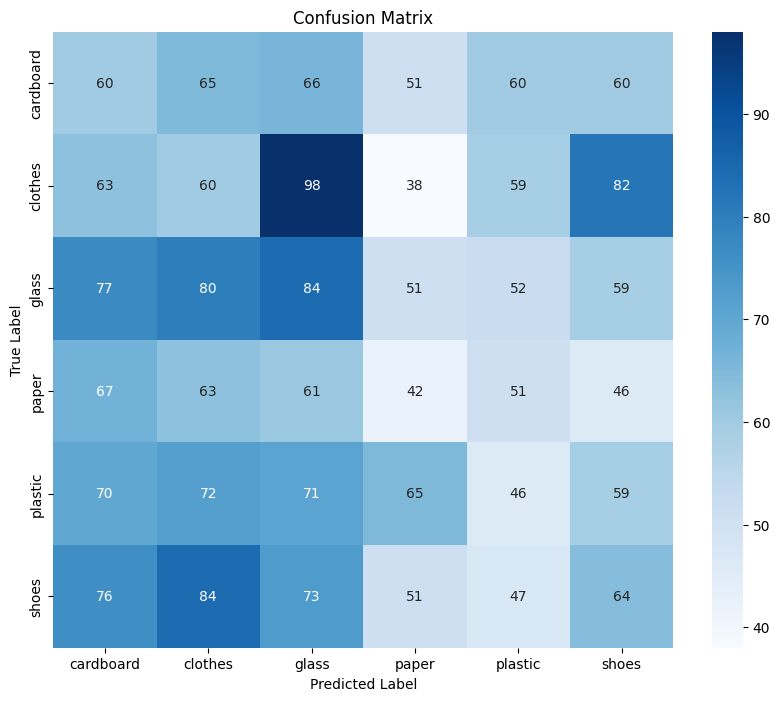

              precision    recall  f1-score   support

   cardboard       0.15      0.17      0.15       362
     clothes       0.14      0.15      0.15       400
       glass       0.19      0.21      0.20       403
       paper       0.14      0.13      0.13       330
     plastic       0.15      0.12      0.13       383
       shoes       0.17      0.16      0.17       395

    accuracy                           0.16      2273
   macro avg       0.16      0.16      0.15      2273
weighted avg       0.16      0.16      0.16      2273



In [38]:
# Confusion Matrix and Classification Report
validation_generator.reset()
Y_pred = model.predict(validation_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = validation_generator.classes
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=validation_generator.class_indices.keys(), yticklabels=validation_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

print(classification_report(y_true, y_pred, target_names=list(validation_generator.class_indices.keys())))


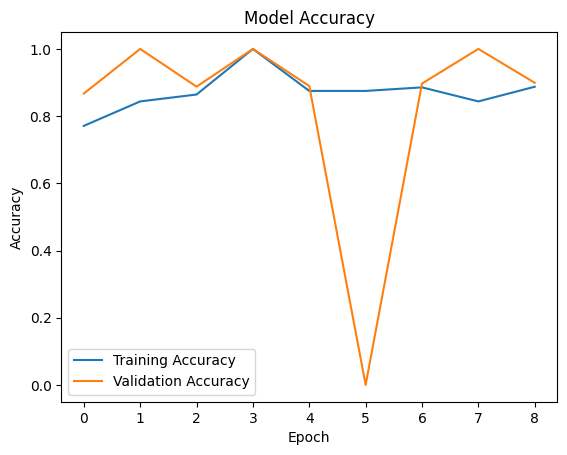

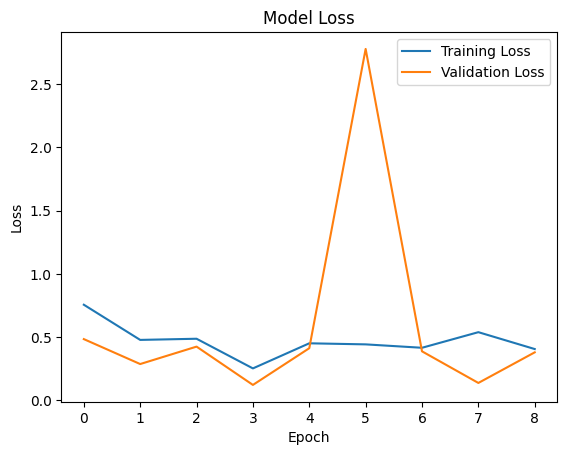

In [39]:
# Plotting training results
plt.plot(r.history['accuracy'], label='Training Accuracy')
plt.plot(r.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(r.history['loss'], label='Training Loss')
plt.plot(r.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [40]:
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

72/72 ━━━━━━━━━━━━━━━━━━━━ 43s 592ms/step


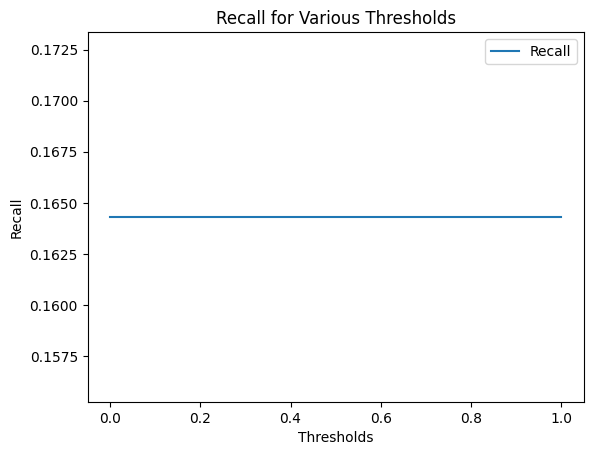

In [45]:
from sklearn.metrics import recall_score
from math import ceil

# Calculate the correct number of steps to cover all samples
steps = ceil(validation_generator.samples / validation_generator.batch_size)

# Load the best model or the last saved model if best model not available
model.load_weights('best_model.keras')

# Predict probabilities ensuring all samples are included
validation_generator.reset()  # Important: resets the generator to the first batch
predictions = model.predict(validation_generator, steps=steps)

# Adjust true_labels to match the number of predictions
true_labels = validation_generator.classes[:len(predictions)]

# Predictions are probabilities of the positive class (class 1)
probabilities = predictions.squeeze()

# Get class predictions instead of probabilities
class_predictions = np.argmax(probabilities, axis=-1)

# Define thresholds from 0 to 1
thresholds = np.linspace(0, 1, 100)
recalls = []
precisions = []

# Calculate recall for each threshold
for threshold in thresholds:
    # Apply threshold
    binary_predictions = (probabilities > threshold).astype(int)
    # You need to make sure binary_predictions matches the shape and type of true_labels
    # For multi-class, you would generally use argmax and not apply a binary threshold directly
    recalls.append(recall_score(true_labels, class_predictions, average='macro'))  # 'macro' to average recall scores of each class

# Plotting recall curve
plt.plot(thresholds, recalls, label='Recall')
plt.xlabel('Thresholds')
plt.ylabel('Recall')
plt.title('Recall for Various Thresholds')
plt.legend()
plt.show()


72/72 ━━━━━━━━━━━━━━━━━━━━ 43s 596ms/step


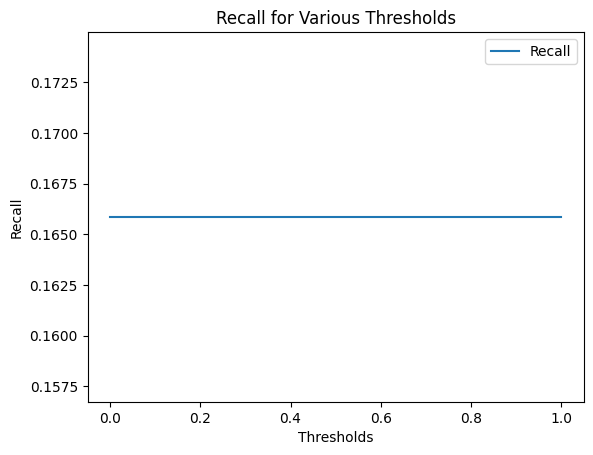

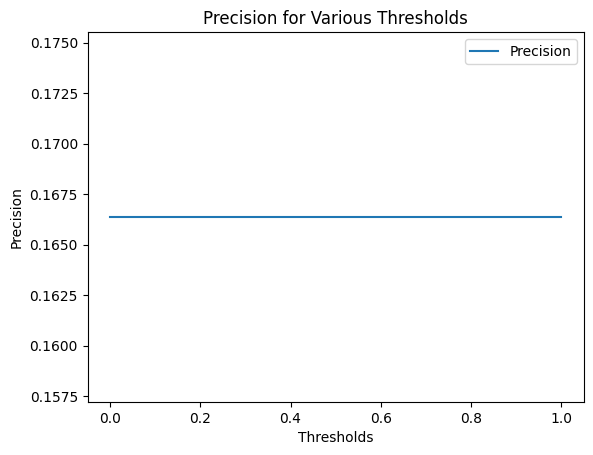

In [48]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score, precision_score
from math import ceil

# Calculate the correct number of steps to cover all samples
steps = ceil(validation_generator.samples / validation_generator.batch_size)

# Load the best model or the last saved model if best model not available
model.load_weights('best_model.keras')

# Predict probabilities ensuring all samples are included
validation_generator.reset()  # Important: resets the generator to the first batch
predictions = model.predict(validation_generator, steps=steps)

# Adjust true_labels to match the number of predictions
true_labels = validation_generator.classes[:len(predictions)]

# Convert predictions to class predictions (argmax for multi-class classification)
class_predictions = np.argmax(predictions, axis=-1)

# Define thresholds from 0 to 1 for binary classification
thresholds = np.linspace(0, 1, 100)
recalls = []
precisions = []

# Calculate recall and precision for each threshold
for threshold in thresholds:
    # Apply threshold
    binary_predictions = (predictions > threshold).astype(int)

    # For multiclass problems, using `argmax` to get class predictions
    if predictions.shape[1] > 1:  # Check if it's a multiclass problem
        binary_predictions = np.argmax(predictions, axis=-1)

    # Ensure precision/recall calculations are handled for multiclass
    recalls.append(recall_score(true_labels, binary_predictions, average='macro'))  # 'macro' to average recall scores of each class
    precisions.append(precision_score(true_labels, binary_predictions, average='macro'))  # 'macro' for averaging precision

# Plotting recall curve
plt.plot(thresholds, recalls, label='Recall')
plt.xlabel('Thresholds')
plt.ylabel('Recall')
plt.title('Recall for Various Thresholds')
plt.legend()
plt.show()

# Plotting precision curve
plt.plot(thresholds, precisions, label='Precision')
plt.xlabel('Thresholds')
plt.ylabel('Precision')
plt.title('Precision for Various Thresholds')
plt.legend()
plt.show()
